<a href="https://colab.research.google.com/github/hisaom0419/my_python/blob/master/Tecan(OD_FL)_20221028.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tecanで測定して得られたワークシートを解析するコード
OD595、FL1を想定している。FLが2色のケースがある場合、また作ります（HM)。

基本的には、96穴、各サンプルを８行に、横１２列サンプル分解析したシートを想定している。ただ、解析ウェルを限った場合にもサンプルシート（sample_file）を対応させることで解析可能。

必須入力項目は必須。
サブコードにもパラメータあり。必要に応じて変更。

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
%pwd
%cd /content/drive/MyDrive/Colab Notebooks
%ls

/content/drive/MyDrive/Colab Notebooks
 1006-ASAHI-ADOPT-Raw-2.xlsx
 20210512_HSF1ts.xlsx
 20210713MGRMFL_fcy1SNUWT_op.xlsx
 AAA.xlsx
 aa_ratio_all.xlsx
 CY_SC-Ura_20221027.xlsx
 CY_SC-Ura_Cu_20221027.xlsx
 Df.xlsx
 Graph_20210427.pdf
 Graph_20210713_fcy1SNUWT_op.pdf
 green_file.xlsx
 Max_aa_list.csv
 MGRまとめ_221004.xlsx
 MGRまとめ_221005-2.xlsx
 MGRまとめ_221005.xlsx
 orf_coding_all.fasta
 PCA.ipynb
 PolyX_finder.ipynb
 PolyX_find.ipynb
 PolyX_FR_counter.ipynb
'python_tutorial_bioinfo_01 のコピー'
 Sample_sheet_CY_221027.xlsx
 Sample_sheet.xlsx
 SC_ORFs.fa
 SC_ORFs.txt
 Sc_ORFtrans.xlsx
 SC_ORF.txt
 SeqIO.ipynb
'Tecan(OD_FL1)_20210429.ipynb のコピー'
'Tecan(OD_FL1)_20210515最新版.ipynb のコピー'
 Untitled0.ipynb
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled3.ipynb


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import fftpack

In [22]:
#もしインストールしていないなら
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
#データ読み込み(ver.1.0.0)

#----必須入力項目----
data_file = 'CY_SC-Ura_20221027.xlsx' #データシート
max_cycle = len(pd.read_excel(data_file).columns) #最大読み取りサイクル数
sample_file = 'Sample_sheet_CY_221027.xlsx' #サンプルシート
graph_color = 'red' #グラフの色
graph_file = 'Graph_20210713_fcy1SNUWT_op.pdf' #グラフの保存ファイル名
writer = pd.ExcelWriter('20210713MGRMFL_fcy1SNUWT_op.xlsx', engine = 'xlsxwriter')
#最大蛍光値・MGRを保存するファイル
#----ここまで----

Sample = pd.read_excel(sample_file, index_col=0).to_dict()["Sample"]
length = len(Sample)

if length == 96:
  df_1 = pd.read_excel(data_file,index_col=0,skiprows=46,nrows=96,header=None,usecols=np.arange(0,max_cycle,1)).dropna(how='all',axis=1)
  df_2 = pd.read_excel(data_file,index_col=0,skiprows=46+96+5,nrows=96,header=None,usecols=np.arange(0,max_cycle,1)).dropna(how='all',axis=1)
  
else:
  df_1 = pd.read_excel(data_file,index_col=0,skiprows=47,nrows=length,header=None,usecols=np.arange(0,max_cycle,1))
  df_2 = pd.read_excel(data_file,index_col=0,skiprows=47+length+5,nrows=length,header=None,usecols=np.arange(0,max_cycle,1))


#ウェル番号とサンプル名をマルチインデックスにしたデータフレームの作成
df_1c = pd.concat([df_1,pd.read_excel(sample_file, index_col=0)], axis=1, join='inner').set_index('Sample',append=1)
df_2c = pd.concat([df_2,pd.read_excel(sample_file, index_col=0)], axis=1, join='inner').set_index('Sample',append=1)

# #df_1をプロット
# df_1c.T.plot(legend=0)

# print(df_1)

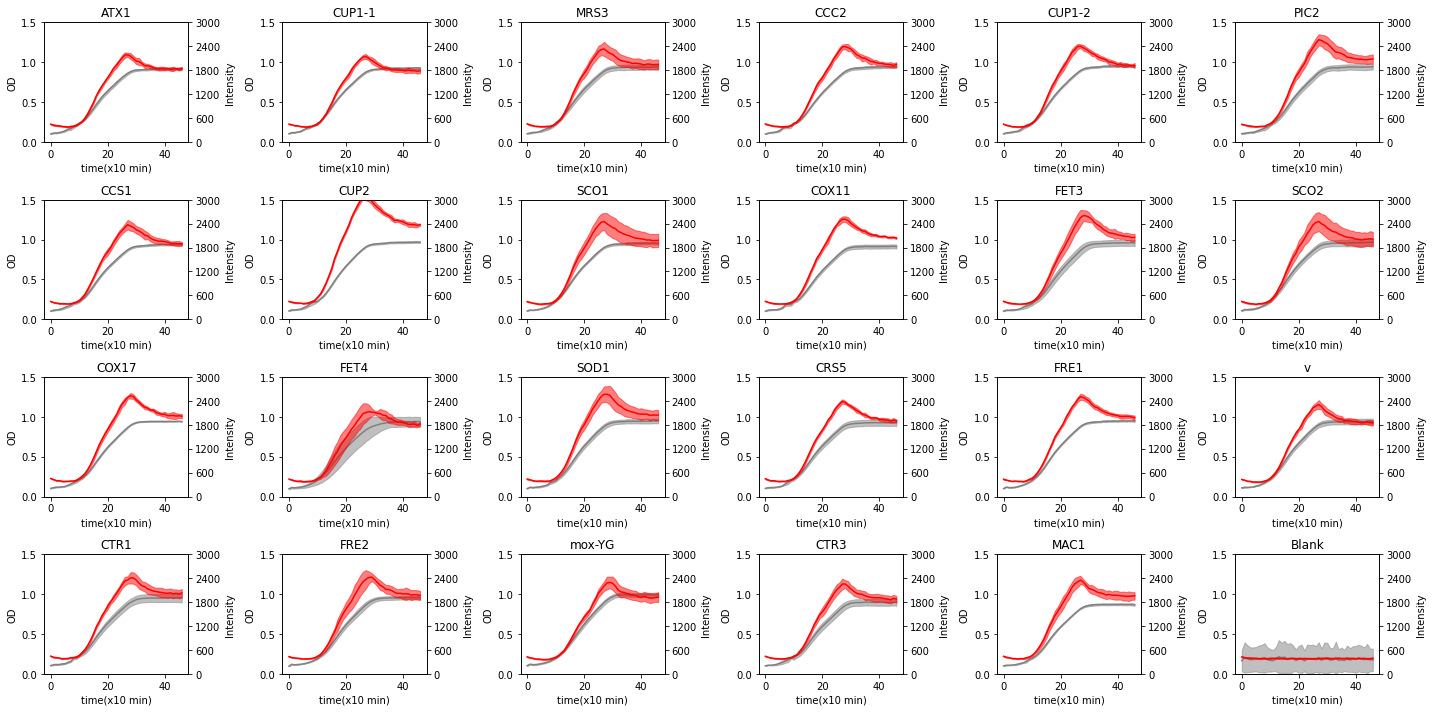

In [27]:
#グラフ一覧作成 (ver.1.0.0)

#~~~~パラメータ~~~~
#グラフの縦軸の最大値
max_OD = 1.5
max_FL = 3000
FL_range = max_FL/5
#~~~~ここまで~~~~

fig=plt.figure(figsize=(20,10))

df_1ave =  df_1c
df_2ave =  df_2c

#振動が発生した場合に使う
#df_1ave =  df_1c.rolling(period,axis=1,center=True,min_periods=1).mean()
#df_2ave =  df_2c.rolling(period,axis=1,center=True,min_periods=1).mean()

n=0
x=np.arange(len(df_1ave.T))

for sample in (list(dict.fromkeys(list(Sample.values())))): #重複なしサンプルリストから１つずつ実行
  n+=1
  #wellを抽出
  wells = [k for k, v in Sample.items() if v == sample]

  tdf1=df_1ave.loc[wells]
  tdf2=df_2ave.loc[wells]

  y1=tdf1.mean(axis=0)
  std1=tdf1.std(axis=0)
  y2=tdf2.mean(axis=0)
  std2=tdf2.std(axis=0)
  y3=y2/y1

  ax1=fig.add_subplot(4,6,n) #サンプル数に応じてグラフの数を変える。デフォルトはmax24
  
  ax1.plot(x,y1,color="gray")
  ax1.fill_between(x,y1-std1,y1+std1,alpha=0.5,color="gray")
  ax1.set_title(sample)
  ax1.set_ylabel("OD")
  ax1.set_xlabel("time(x10 min)")
  ax1.set_ylim(0, max_OD)
  
  ax2 = ax1.twinx() #2軸のグラフを描くため
  ax2.plot(x,y2,color=graph_color)
  ax2.fill_between(x,y2-std2,y2+std2,alpha=0.5,color=graph_color)
  ax2.set_ylim(0, max_FL)
  ax2.set_yticks(np.arange(0,max_FL+1,FL_range))
  ax2.set_ylabel("Intensity")

  # ax3 = ax1.twinx() #2軸のグラフを描くため
  # ax3.plot(x,y3,color='blue')
  # ax3.set_ylim(0, 2000)

plt.tight_layout()
plt.show()

#グラフを保存
fig.savefig(graph_file)

In [30]:
#MGR算出ファイル（ver.2.0.1）
# R2 > Thresholdのサンプルがない場合には、"zero-size array" エラーが出るが気にしない。あるいはThresholdをとても低く設定する。

#~~~~パラメータ~~~~
Period = 30 #測定間隔（min）
Range = 10 #GRを算出するレンジ
Step_size = 1 #移動測定数（大きくすると処理が早くなる）
Threshold = 0.01 #R2の閾値を指定
#~~~~ここまで~~~~

#データをログ変換
OD_log2 = np.log2(df_1ave).dropna()
Max_cycle = len(OD_log2.columns)-1
#print(Max_cycle)
Well_Num = len(OD_log2) 
x = np.arange(Range)

MGR = OD_log2[1]

#WellごとにTimeウインドウを移動しながらGR（直線回帰の傾き=SlopeとR2を取得）、R2のThreshold以上のSlopeを返す（Threshold以下だと0.01を返す）。
#最終的なGRは測定時間間隔（Period）で割り(min-1)、便宜的に10をかけている。

for index in MGR.index:
  Cycle = 0
  n = 0
  Slope  = np.array([])
  R2 = np.array([])
  OD_list = OD_log2.loc[index].values


  while Cycle < Max_cycle-Range:
    #OD_list2 = OD_list[Cycle:Cycle+Range]
    OD_list2 = np.roll(OD_list,Cycle)[0:Range]
    Slope = np.insert(Slope,n,(np.polyfit(x,OD_list2,1)[0]*100))
    R2 = np.insert(R2,n,(np.corrcoef(x,OD_list2)[0][1]**2))
    Cycle += Step_size
    n += 1

  GR = np.array([x for x in Slope[R2 > Threshold]])/Period*10
  MGR[index] = GR.max()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


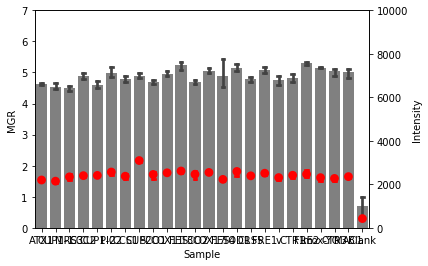

/usr/local/lib/python3.7/dist-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [31]:
#MGRと最高蛍光値のグラフ化、保存（ver.1.1.0）

#~~~~パラメータ~~~~
MGR_max =7 #MGRグラフ最大値
MFL_max = 10000 #MFLグラフ最大値
#~~~~ここまで~~~~


fig=plt.figure()

ax1=fig.add_subplot()
ax1=sns.barplot(MGR.index.get_level_values('Sample'), MGR.values,color='gray',capsize=0.2)
#ax1=sns.stripplot(MGR.index.get_level_values('Sample'), MGR.values,color='gray')
ax1.set_ylabel("MGR")
ax1.set_ylim(0, MGR_max)

MFL = df_2ave.max(axis=1)

ax2 = ax1.twinx() #2軸のグラフを描くため
ax2=sns.pointplot(MFL.index.get_level_values('Sample'), MFL.values,color=graph_color,join=False,capsize=0.2)
#ax2=sns.barplot(MFL.index.get_level_values('Sample'), MFL.values,color=graph_color)

ax2.set_ylabel("Intensity")
ax2.set_ylim(0, MFL_max)

plt.show()


#データ保存
MFL.to_excel(writer, sheet_name = 'MFL')
MGR.to_excel(writer, sheet_name = 'MGR')

writer.save()
writer.close()

In [ ]:
#テカンで振動が発生した場合には以下を実行する

#周期（period）検出(ver.1.0.0)

#サイクル数が偶数値でないといけない

#~~~~パラメータ~~~~
Start = 0 #周期検出の最初
End = 400 #周期検出の最後
Threshold = 0.1 #閾値を設定
Max_Cycle = 100 #最大周期を設定
#~~~~ここまで~~~~

df = df_1.T.loc[Start:End]

if len(df)%2 != 0:
  print('測定サイクル数を偶数値にしてください！')

else:
  all_period = []

  for column_name in df:
    f = df[column_name].values 
    t = np.arange(len(f)) 

    assert t.size == f.size  # 時間軸の長さとデータの長さが同じであることを確認する
    assert np.unique(np.diff(t)).size == 1  # 時間間隔が全て一定であることを確認する

    T = (t[1] - t[0]) * t.size
    period = 1.0 / (np.arange(t.size / 2)[1:] / T)

    # パワースペクトル密度を計算
    f = f - np.average(f)         # 平均をゼロに。
    F = fftpack.fft(f)                          # 高速フーリエ変換
    Po = np.abs(F[1:(t.size // 2)]) ** 2 / T
    
    dominant_periods = [x for x in period[Po > Threshold] if x <= Max_Cycle]

    n=0
    for x in dominant_periods:
      all_period.append(dominant_periods[n])
      n=n+1
      
  period = round(np.mean(all_period))
  print('周期は',period,'です。')

In [ ]:

#サイクル処理の確認 (ver.1.0.0)
Df =  df_1c.rolling(period,axis=1,center=True,min_periods=1).mean()
Df.T.plot(legend=0)

#サンプルごとのデータをグラフ化
Df.xs('No.10', level=1).T.plot()